<a href="https://colab.research.google.com/github/aashrithresearch/WoundAI/blob/main/models/densenet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
import torch
import os

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aashrithy","key":"f62ff5af191bbbb6f7d19b80dc67c84b"}'}

In [4]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download 'ibrahimfateen/wound-classification'

Dataset URL: https://www.kaggle.com/datasets/ibrahimfateen/wound-classification
License(s): unknown
 81% 73.0M/89.8M [00:00<00:00, 94.5MB/s]
100% 89.8M/89.8M [00:00<00:00, 98.0MB/s]


In [ ]:
! unzip /content/wound-classification.zip -d /content

In [7]:
fnames = '/content/Wound_dataset copy'

In [8]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms = Resize(224),
                   batch_tfms = aug_transforms(mult=2))
dls = dblock.dataloaders(fnames, bs=32)

In [9]:
train_ds = dls.train_ds
dls = dblock.dataloaders(fnames)
from collections import Counter
class_counts = Counter([train_ds.items[i].parent.name for i in range(len(train_ds))])

print("Number of samples per class in the training set:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the training set:
Pressure Wounds: 487
Surgical Wounds: 344
Diabetic Wounds: 374
Bruises: 190
Burns: 102
Venous Wounds: 387
Normal: 165
Laseration: 102
Abrasions: 128
Cut: 73


In [10]:
valid_ds = dls.valid_ds
valid_class_counts = Counter([valid_ds.items[i].parent.name for i in range(len(valid_ds))])


print("\nNumber of samples per class in the validation set:")
for cls, count in valid_class_counts.items():
    print(f"{cls}: {count}")


Number of samples per class in the validation set:
Diabetic Wounds: 88
Pressure Wounds: 115
Abrasions: 36
Venous Wounds: 107
Bruises: 52
Laseration: 20
Normal: 35
Cut: 27
Surgical Wounds: 76
Burns: 32


In [11]:
from math import ceil
batch = dls.one_batch()
batch_size = batch[0].shape[0]
ncols = 10
nrows = ceil(batch_size / ncols)

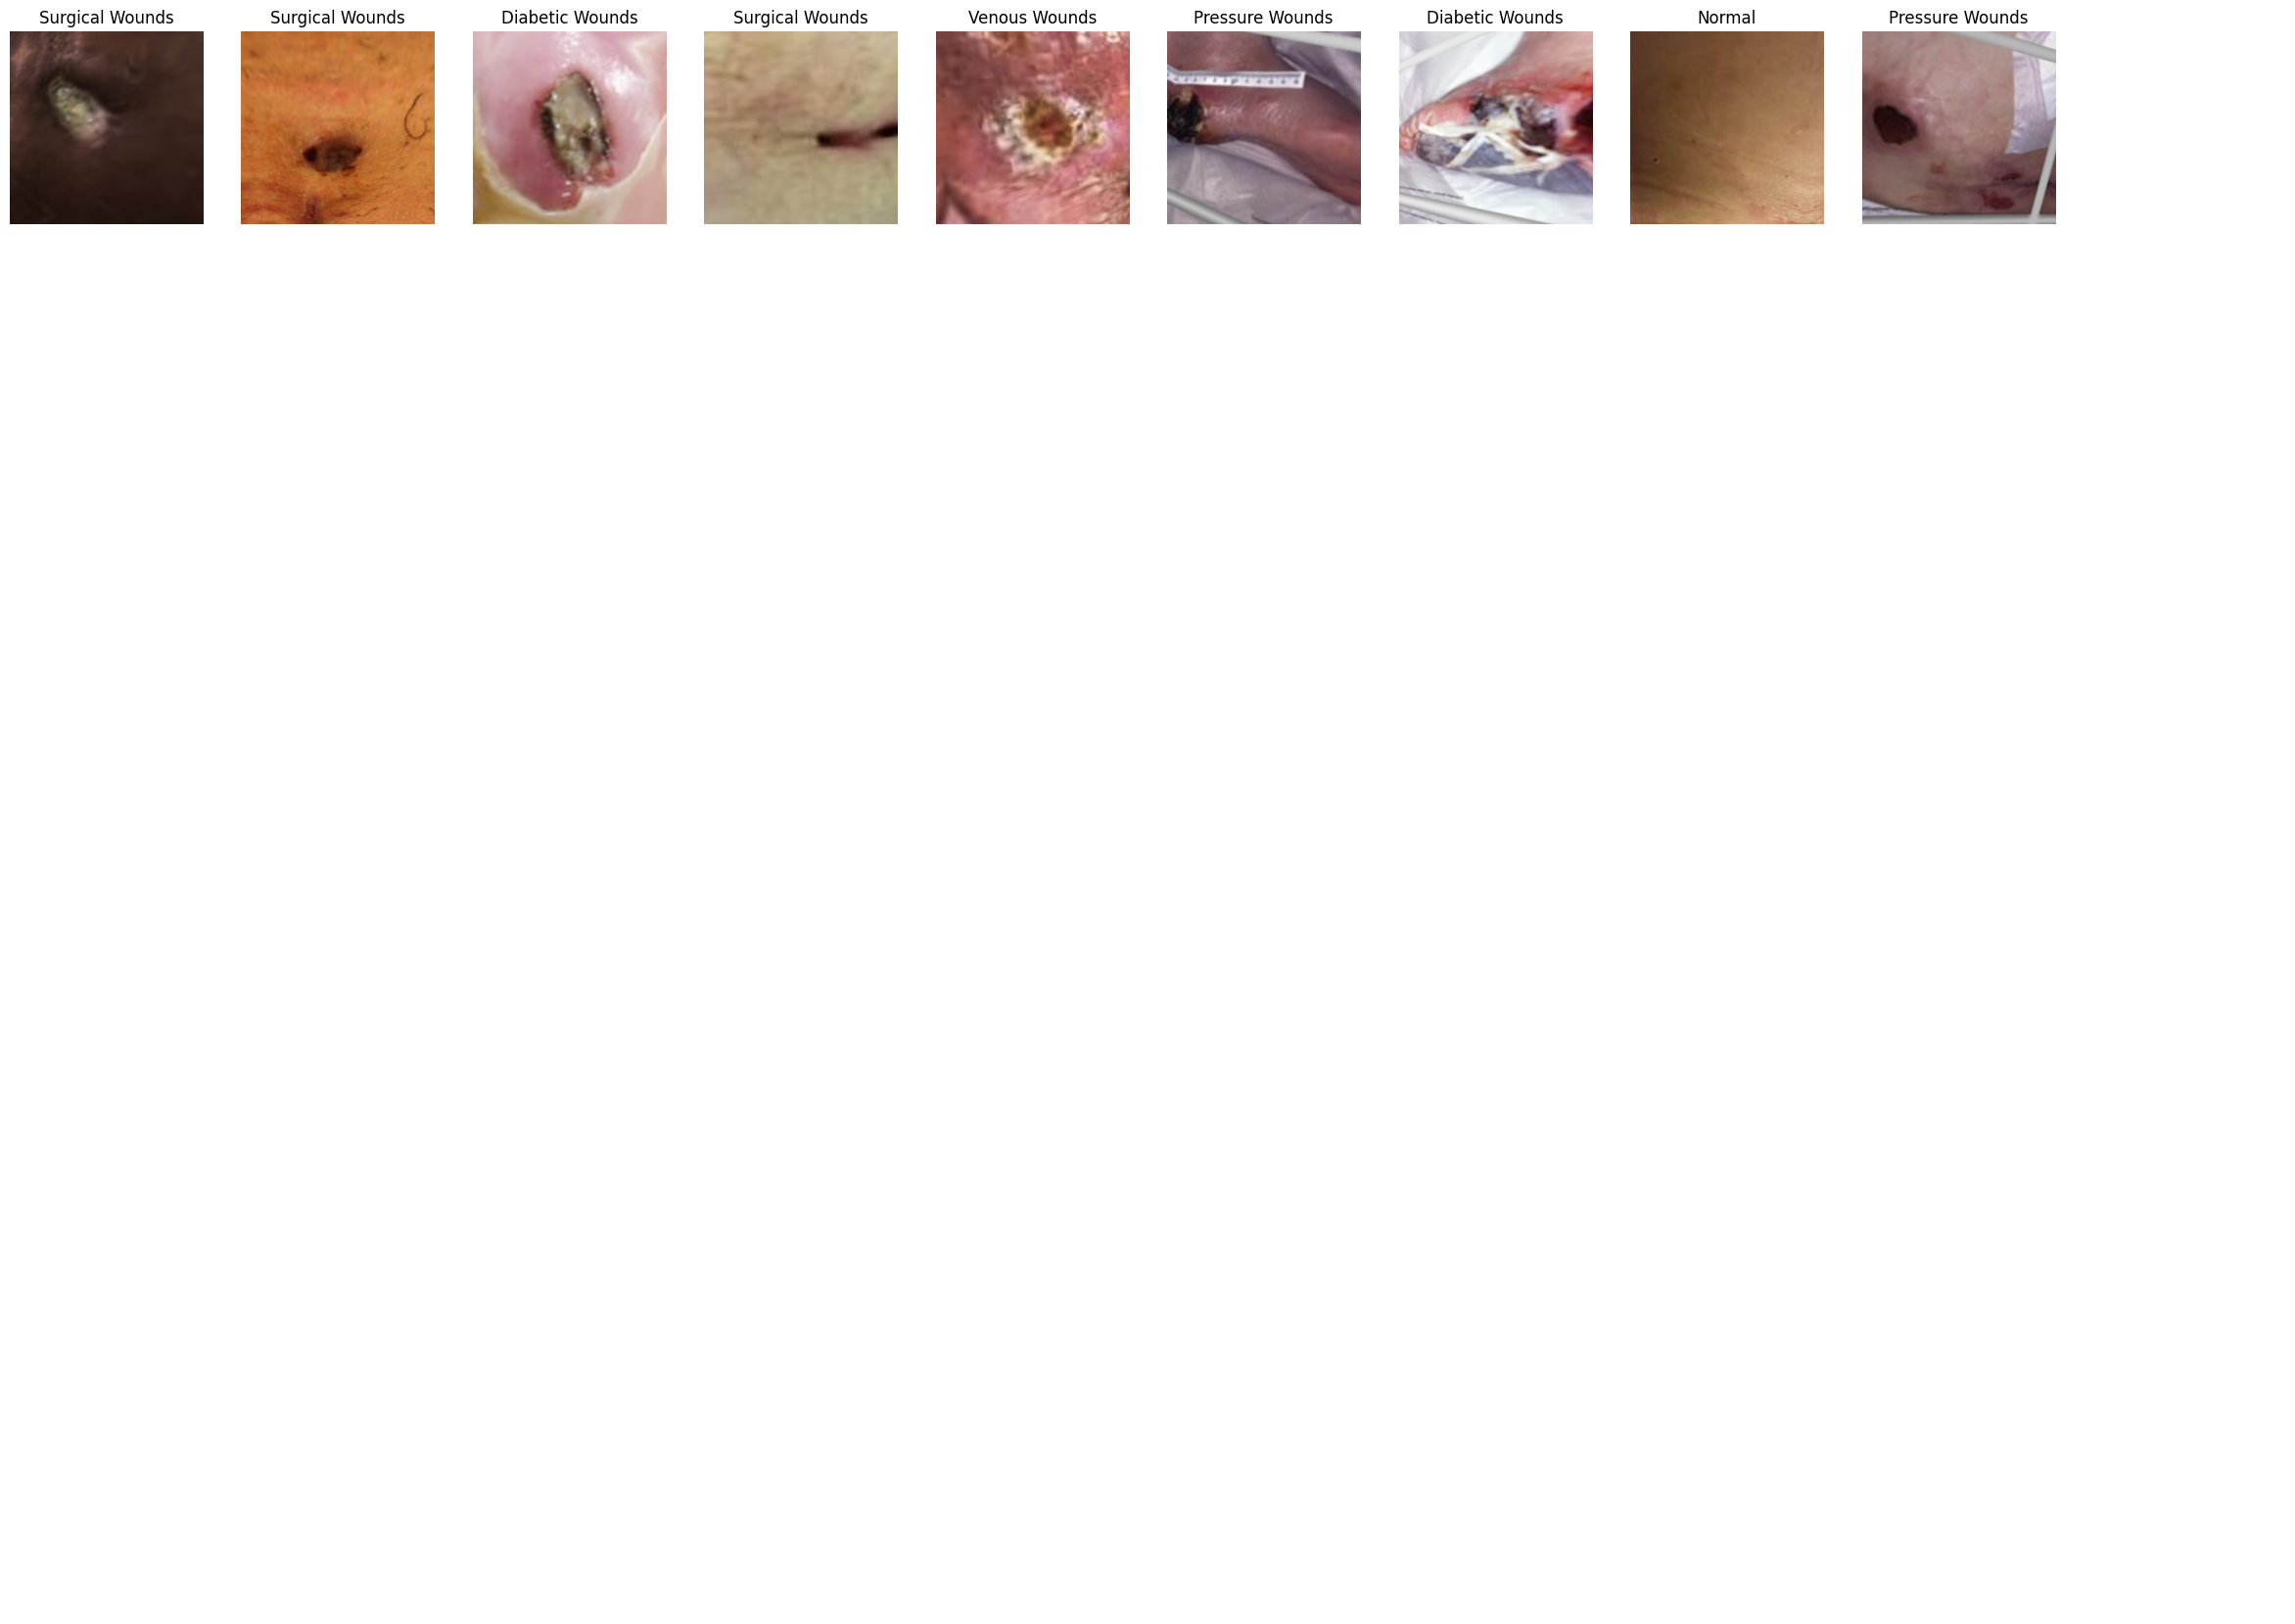

In [12]:
dls.show_batch(nrows=nrows, ncols=10)

In [13]:
metrics =  [
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro'),
    RocAuc(average='macro')
]
learn169 = vision_learner(dls, densenet169, metrics=metrics, loss_func=FocalLoss(), opt_func=Adam).to_fp16()

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 161MB/s]


SuggestedLRs(valley=0.0005754399462603033)

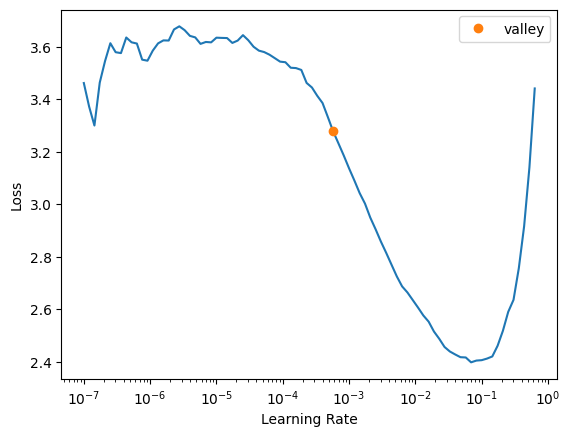

In [14]:
learn169.lr_find()

In [15]:
learn169.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,3.575320,2.481622,0.105442,0.118723,0.103432,0.094075,0.520105,00:20
1,3.271865,1.951728,0.209184,0.223237,0.212316,0.193725,0.652972,00:23
2,2.709055,1.227990,0.465986,0.421552,0.447492,0.413222,0.828902,00:20
3,2.184379,0.861354,0.634354,0.616893,0.635617,0.610932,0.910179,00:21
4,1.788777,0.683007,0.700680,0.706409,0.700659,0.692484,0.941918,00:23
5,1.454348,0.574113,0.739796,0.744469,0.747074,0.738227,0.958755,00:21
6,1.199008,0.507918,0.775510,0.781280,0.788548,0.779191,0.966944,00:20
7,1.042161,0.457125,0.789116,0.805462,0.808348,0.800850,0.972270,00:23
8,0.943378,0.436055,0.789116,0.799657,0.806573,0.799257,0.974091,00:20
9,0.819787,0.401088,0.806122,0.826637,0.823624,0.820717,0.978032,00:21


SuggestedLRs(valley=7.585775892948732e-05)

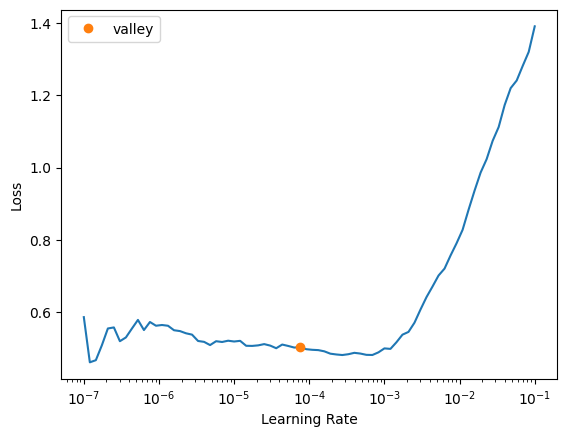

In [16]:
learn169.unfreeze()
learn169.lr_find()

In [17]:
learn169.fit_one_cycle(20, 1e-5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.517146,0.280575,0.846939,0.860765,0.866471,0.860566,0.986754,00:24
1,0.508282,0.284521,0.845238,0.860265,0.865155,0.859914,0.987044,00:22
2,0.494630,0.279853,0.838435,0.852409,0.864713,0.855780,0.987618,00:23
3,0.498821,0.253802,0.848639,0.869536,0.865483,0.863746,0.988737,00:26
4,0.479691,0.248338,0.858844,0.876004,0.877208,0.872013,0.989678,00:22
5,0.458065,0.235949,0.863946,0.883866,0.878399,0.877762,0.990086,00:23
6,0.447480,0.218019,0.860544,0.875539,0.879043,0.873962,0.991129,00:22
7,0.438410,0.212773,0.874150,0.889099,0.893262,0.888591,0.991504,00:24
8,0.406617,0.210954,0.877551,0.894879,0.898109,0.893192,0.991809,00:24
9,0.399084,0.200349,0.889456,0.903317,0.906006,0.902066,0.992490,00:24


SuggestedLRs(valley=0.00015848931798245758)

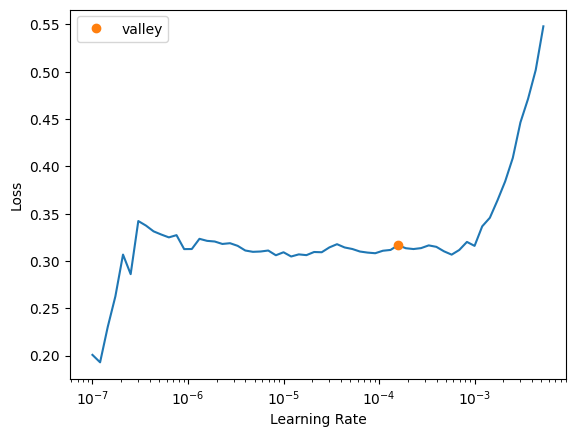

In [18]:
learn169.unfreeze()
learn169.lr_find()

In [20]:
learn169.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.198002,0.182678,0.899660,0.917756,0.919646,0.914477,0.994825,00:31
1,0.195399,0.166775,0.904762,0.924193,0.921450,0.919476,0.995325,00:24
2,0.204337,0.162071,0.903061,0.919993,0.919172,0.917073,0.995379,00:24
3,0.209214,0.157606,0.909864,0.922073,0.923451,0.920375,0.995737,00:24
4,0.192327,0.160633,0.911565,0.927283,0.928327,0.925372,0.995769,00:23
5,0.201898,0.144661,0.916667,0.929184,0.931584,0.927620,0.996282,00:23
6,0.199465,0.138170,0.921769,0.932819,0.938274,0.933668,0.996407,00:24
7,0.177837,0.131898,0.926871,0.936021,0.940970,0.936646,0.996707,00:24
8,0.169977,0.144433,0.918367,0.930057,0.932449,0.929041,0.996465,00:22
9,0.176438,0.133189,0.925170,0.937468,0.940367,0.937319,0.996794,00:25


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.198002,0.182678,0.899660,0.917756,0.919646,0.914477,0.994825,00:31
1,0.195399,0.166775,0.904762,0.924193,0.921450,0.919476,0.995325,00:24
2,0.204337,0.162071,0.903061,0.919993,0.919172,0.917073,0.995379,00:24
3,0.209214,0.157606,0.909864,0.922073,0.923451,0.920375,0.995737,00:24
4,0.192327,0.160633,0.911565,0.927283,0.928327,0.925372,0.995769,00:23
5,0.201898,0.144661,0.916667,0.929184,0.931584,0.927620,0.996282,00:23
6,0.199465,0.138170,0.921769,0.932819,0.938274,0.933668,0.996407,00:24
7,0.177837,0.131898,0.926871,0.936021,0.940970,0.936646,0.996707,00:24
8,0.169977,0.144433,0.918367,0.930057,0.932449,0.929041,0.996465,00:22
9,0.176438,0.133189,0.925170,0.937468,0.940367,0.937319,0.996794,00:25
